# NLP Project: Sentiment Analysis

## Part 3: Keras & LSTM

In this notebook I use Keras to build a neural network as well as the LSTM

**Outline**:

- Keras
- RNN
- LSTM


**Pipeline**

<img src="resources/pipeline.png" width="800px">

In [2]:
from ml_utils import *

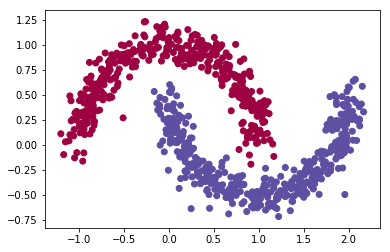

In [3]:
X_train, X_test, Y_train, Y_test = load_moon()
plt.scatter(X_train[0,:], X_train[1,:],c=Y_train[0],cmap=plt.cm.Spectral)

In [4]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation

Using TensorFlow backend.


** Steps of using Keras: **

1. Define the structure of the network. 
2. Print the summary of your network to see if shape and #of params is correct.
3. **Compile the model**.
4. Fit the model.
5. Evaluate the model.

In [5]:
X_train.shape

(2, 800)

In [6]:
model = Sequential()
model.add(Dense(4, input_dim=2, activation='tanh'))  # hidden layer
model.add(Dense(1, activation='sigmoid'))  # output layer
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


<img src="resources/keras_network.png" width="800">

<center>*Keras 2-layer neural network*</center>

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
X_train.T.shape

(800, 2)

In [9]:
model.fit(X_train.T, Y_train.T, epochs=100)

Epoch 1/100
800/800 [==============================] - 0s 463us/step - loss: 0.7888 - acc: 0.2950
Epoch 2/100
800/800 [==============================] - 0s 38us/step - loss: 0.7526 - acc: 0.3375
Epoch 3/100
800/800 [==============================] - 0s 41us/step - loss: 0.7201 - acc: 0.4300
Epoch 4/100
800/800 [==============================] - 0s 36us/step - loss: 0.6908 - acc: 0.5575
Epoch 5/100
800/800 [==============================] - 0s 34us/step - loss: 0.6649 - acc: 0.7650
Epoch 6/100
800/800 [==============================] - 0s 35us/step - loss: 0.6409 - acc: 0.8712
Epoch 7/100
800/800 [==============================] - 0s 37us/step - loss: 0.6194 - acc: 0.8738
Epoch 8/100
800/800 [==============================] - 0s 36us/step - loss: 0.5995 - acc: 0.8650
Epoch 9/100
800/800 [==============================] - 0s 35us/step - loss: 0.5809 - acc: 0.8600
Epoch 10/100
800/800 [==============================] - 0s 35us/step - loss: 0.5636 - acc: 0.8562
Epoch 11/100
800/800 [======

In [10]:
model.evaluate(X_train.T, Y_train.T)

800/800 [==============================] - 0s 69us/step


[0.2554926970601082, 0.8875]

In [11]:
model.evaluate(X_test.T, Y_test.T)

200/200 [==============================] - 0s 35us/step


[0.28012958765029905, 0.865]

<span style="color:red">**Notes:**</span>

Another good practice to create a model is to treat each layer as a "transformer" or a "function" that helps us to map the input (training features) to the output (labels).

In [12]:
def simple_nn_model():
    X = Input(shape=(2,))
    Z = Dense(4, activation='tanh')(X)
    Y = Dense(1, activation='sigmoid')(Z)
    return Model(inputs=X, outputs=Y)

In [13]:
model2 = simple_nn_model()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


### LSTM

> For more intuitive explanation of LSTM, you may refer to [this post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

In [14]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from keras.preprocessing import sequence

np.random.seed(1)

<img src="resources/deep_lstm.png" style="width:700px;height:400px;"> <br>
<caption><center> A 2-layer LSTM sequence classifier. </center></caption>

In [15]:
X_train, X_test, Y_train, Y_test = load_emoji()

In [16]:
word_to_index, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

2 dictionaries are loaded:

- `word_to_index`: dictionary mapping from words to their indices in the vocabulary (400,001 words, with the valid indices ranging from 0 to 400,000).
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

The reason we need `word_to_index` is that when adding a custom embedding layer in Keras, we can only load the pretrained embedding as a matrix instead of a dictionary. A index will help us find the correct entry for a given word.

In [17]:
# Encode the sentence to the index array
X_tmp = np.array(["I like it"])
sentences_to_indices(X_tmp, word_to_index, max_len = 5)

array([[185457., 222471., 193716.,      0.,      0.]])

<span style="color:red">**Notes:**</span>: `sentences_to_indices` is provided in `ml_utils`.

#### Embedding Layer

We need to build a embedding matrix where each row represent a word vector.

In [18]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Build and return a Keras Embedding Layer given word_to_vec mapping and word_to_index mapping
    
    Args:
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)
        word_to_index (dict[str->int]): map from a word to its index in vocabulary

    Return:
        Keras.layers.Embedding: Embedding layer
    """
    
    # Keras requires vocab length start from index 1
    vocab_len = len(word_to_index) + 1  
    emb_dim = list(word_to_vec_map.values())[0].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    return Embedding(
        input_dim=vocab_len, 
        output_dim=emb_dim, 
        trainable=False,  # Indicating this is a pre-trained embedding 
        weights=[emb_matrix])

> For more information on how to define a pre-trained embedding layer in Keras, please refer to [this post](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

In [19]:
def emoji_model(input_shape, word_to_vec_map, word_to_index):
    """
    Build and return the Keras model
    
    Args:
        input_shape (np.ndarray): The shape of input layer, usually it means (#training_example, max_len)
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
    
    Returns:
        Keras.models.Model: 2-layer LSTM model
    """
    
    # Input layer
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    # 2-layer LSTM
    X = LSTM(128, return_sequences=True, recurrent_dropout=0.5)(embeddings)  # N->N RNN
    X = Dropout(0.5)(X)
    X = LSTM(128, recurrent_dropout=0.5)(X)  # N -> 1 RNN
    X = Dropout(0.5)(X)
    X = Dense(5, activation='softmax')(X)
    
    # Create and return model
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [20]:
maxlen = len(max(X_train, key=len).split())
print(maxlen)

10


In [21]:
model = emoji_model((maxlen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total para

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Convert training/testing features into index list
X_train_indices = sentences_to_indices(X_train, word_to_index, maxlen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxlen)

# Convert training/testing labels into one hot array
Y_train_oh = convert_to_one_hot(Y_train, C = 5)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

In [24]:
history = model.fit(
    X_train_indices, 
    Y_train_oh, 
    epochs = 50, 
    batch_size = 32, 
    shuffle=True)

Epoch 1/50
132/132 [==============================] - 2s 18ms/step - loss: 1.5772 - acc: 0.2500
Epoch 2/50
132/132 [==============================] - 0s 949us/step - loss: 1.5428 - acc: 0.3106
Epoch 3/50
132/132 [==============================] - 0s 859us/step - loss: 1.5056 - acc: 0.3712
Epoch 4/50
132/132 [==============================] - 0s 855us/step - loss: 1.4907 - acc: 0.3864
Epoch 5/50
132/132 [==============================] - 0s 986us/step - loss: 1.4113 - acc: 0.4318
Epoch 6/50
132/132 [==============================] - 0s 856us/step - loss: 1.3900 - acc: 0.4545
Epoch 7/50
132/132 [==============================] - 0s 895us/step - loss: 1.3440 - acc: 0.4924
Epoch 8/50
132/132 [==============================] - 0s 934us/step - loss: 1.2681 - acc: 0.4621
Epoch 9/50
132/132 [==============================] - 0s 871us/step - loss: 1.2099 - acc: 0.5758
Epoch 10/50
132/132 [==============================] - 0s 862us/step - loss: 1.1238 - acc: 0.5833
Epoch 11/50
132/132 [=========

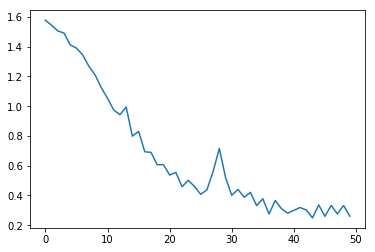

In [25]:
plt.plot(history.history['loss'])

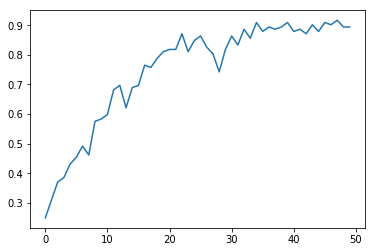

In [26]:
plt.plot(history.history['acc'])

In [27]:
loss, acc = model.evaluate(X_train_indices, Y_train_oh)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

132/132 [==============================] - 0s 3ms/step
loss = 0.1283, acc = 96.21%


In [28]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

56/56 [==============================] - 0s 327us/step
loss = 0.3129, acc = 87.50%


### Save & Load Model

Usually we will save the model structure and weights separately.

> This makes it easy to manage multiple versions of weights and you can always choose which version to go for production.

In [29]:
import h5py

In [30]:
# Save model structure
with open("emoji_model.json", "w") as fp:
    fp.write(model.to_json())

# Save model weights
model.save_weights("emoji_model.h5")

In [31]:
from keras.models import model_from_json

# Load model structure
with open("emoji_model_best.json", "r") as fp:
    model = model_from_json(fp.read())

# Load model weights
model.load_weights("emoji_model_best.h5")

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
loss, acc = model.evaluate(X_train_indices, Y_train_oh)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

132/132 [==============================] - 1s 4ms/step
loss = 0.0002, acc = 100.00%


In [34]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

56/56 [==============================] - 0s 372us/step
loss = 0.2815, acc = 92.86%


In [35]:
x_test = np.array(["i am feeling not happy"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxlen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

i am feeling not happy 😞


### IMDB Dataset

In [36]:
from keras.preprocessing import sequence
from keras.datasets import imdb

In [37]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [38]:
# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=80)
x_test = sequence.pad_sequences(x_test, maxlen=80)
x_train.shape

(25000, 80)

In [39]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [42]:
batch_size = 32

model.fit(x_train, 
          y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 109s 4ms/step - loss: 0.4626 - acc: 0.7821 - val_loss: 0.3908 - val_acc: 0.8295
Epoch 2/15
25000/25000 [==============================] - 107s 4ms/step - loss: 0.3082 - acc: 0.8728 - val_loss: 0.3762 - val_acc: 0.8339
Epoch 3/15
25000/25000 [==============================] - 106s 4ms/step - loss: 0.2203 - acc: 0.9144 - val_loss: 0.4440 - val_acc: 0.8216
Epoch 4/15
25000/25000 [==============================] - 105s 4ms/step - loss: 0.1566 - acc: 0.9419 - val_loss: 0.4738 - val_acc: 0.8290
Epoch 5/15
25000/25000 [==============================] - 103s 4ms/step - loss: 0.1096 - acc: 0.9602 - val_loss: 0.5509 - val_acc: 0.8258
Epoch 6/15
25000/25000 [==============================] - 102s 4ms/step - loss: 0.0789 - acc: 0.9722 - val_loss: 0.6658 - val_acc: 0.8206
Epoch 7/15
25000/25000 [==============================] - 102s 4ms/step - loss: 0.0589 - acc: 0.9802 - val_loss: 0.7159 - 

> In production, you should split your data into 3 parts: training data, validation data and test data. You should not feed `validation_data` with test data like we did here. This is only for quick test.

In [43]:
# Save model structure
with open("imdb_model.json", "w") as fp:
    fp.write(model.to_json())

# Save model weights
model.save_weights("imdb_model.h5")

### TODO

- Use our pre-trained model to replace the Embedding layer and train the model for 30 epochs.
- Collect the training history data
- Plot the accuracy and loss
- Find the best epoch number to stop traning
- Retrain the model and save it for later use.

### Answer

In [44]:
model2 = Sequential()
model2.add(pretrained_embedding_layer(word_to_vec_map, word_to_index))
model2.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

In [45]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          20000050  
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 20,091,827
Trainable params: 91,777
Non-trainable params: 20,000,050
_________________________________________________________________


In [46]:
model2.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [47]:
batch_size = 32

history = model2.fit(x_train, 
                     y_train,
                     batch_size=batch_size,
                     epochs=30,
                     validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/30
25000/25000 [==============================] - 76s 3ms/step - loss: 0.6776 - acc: 0.5622 - val_loss: 0.6653 - val_acc: 0.5789
Epoch 2/30
25000/25000 [==============================] - 75s 3ms/step - loss: 0.6541 - acc: 0.5938 - val_loss: 0.6319 - val_acc: 0.6201
Epoch 3/30
25000/25000 [==============================] - 78s 3ms/step - loss: 0.6232 - acc: 0.6337 - val_loss: 0.6044 - val_acc: 0.6484
Epoch 4/30
25000/25000 [==============================] - 77s 3ms/step - loss: 0.6018 - acc: 0.6507 - val_loss: 0.5858 - val_acc: 0.6746
Epoch 5/30
25000/25000 [==============================] - 77s 3ms/step - loss: 0.5829 - acc: 0.6724 - val_loss: 0.5859 - val_acc: 0.6700
Epoch 6/30
25000/25000 [==============================] - 77s 3ms/step - loss: 0.5645 - acc: 0.6897 - val_loss: 0.5804 - val_acc: 0.6774
Epoch 7/30
25000/25000 [==============================] - 77s 3ms/step - loss: 0.5491 - acc: 0.7068 - val_loss: 0.5468 - val_acc

In [48]:
h = history.history.copy()

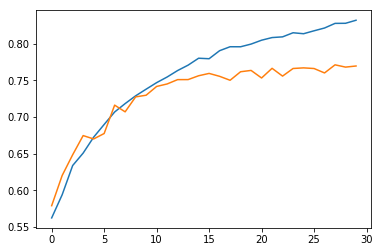

In [49]:
plt.plot(h['acc'])
plt.plot(h['val_acc'])

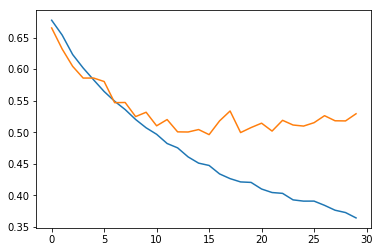

In [50]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])